- Insert necessary library


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import warnings
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.cluster import DBSCAN
from collections import Counter

# Time series / forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

# Scikit-learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

warnings.filterwarnings('ignore')


**1. Demand Clustering and Segmentation into each region based on location**

In [22]:
# Correct file path (remove extra space in 'Deakin /2025')
file_path = '/content/drive/MyDrive/SIT764/Data/clean_data.csv'

# Read the Excel file (you can specify the sheet if needed)
clean_data = pd.read_csv(file_path)

# Display the first 5 rows
clean_data.head(5)


,Date,station_id,Station name,Number of station,Number of plugs,Latitude,Longitude,day_of_week,public_holiday,school_holiday,Avg_Temp,Avg_Humidity,Avg_Wind,is_weekend,daily_total,estimated_demand_kWh
0,2020-01-01,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,3.0,0.0,1.0,22.43,70.00,20.96,0.0,1507.0,26464.81
1,2020-01-02,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,4.0,0.0,1.0,22.43,70.00,20.96,0.0,1507.0,26464.81
2,2020-01-03,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,5.0,0.0,1.0,24.80,73.50,18.02,0.0,1583.0,27640.15
3,2020-01-04,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,6.0,0.0,1.0,30.10,54.04,27.47,1.0,2559.0,44002.65
4,2020-01-05,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,7.0,0.0,1.0,22.28,66.84,34.90,1.0,2268.0,39050.06


In [23]:
# Count number of uniques
clean_data['station_id'].nunique()

270

In [24]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

In [25]:
from sklearn.neighbors import NearestNeighbors
station_locs = (clean_data
    .groupby('station_id', as_index=False)
    .agg(Latitude=('Latitude', 'first'),
         Longitude=('Longitude', 'first'))
)

coords_rad = np.radians(station_locs[['Latitude','Longitude']].astype('float32').to_numpy())
EARTH_R = 6371.0088  # km


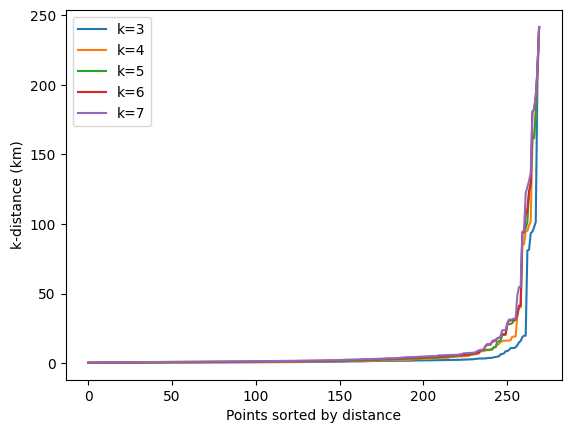

In [26]:
for k in [3,4,5,6,7]:
    nn = NearestNeighbors(n_neighbors=k, metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R
    plt.plot(kdist_km, label=f'k={k}')

plt.ylabel("k-distance (km)")
plt.xlabel("Points sorted by distance")
plt.legend()
plt.show()


In [27]:
from numpy import percentile
results = []
for k in [4,5,6]:
    nn = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', metric='haversine')
    nn.fit(coords_rad)
    dist_rad, _ = nn.kneighbors(coords_rad)
    kdist_km = np.sort(dist_rad[:, -1]) * EARTH_R

    for q in [70,75,80,85,90]:
        eps_km = float(percentile(kdist_km, q))
        eps_rad = eps_km / EARTH_R
        db = DBSCAN(eps=eps_rad, min_samples=k, metric='haversine', algorithm='ball_tree')
        labels = db.fit_predict(coords_rad)
        n_clusters = len(set(labels) - {-1})
        noise_pct = (labels == -1).mean() * 100
        results.append((k, q, eps_km, n_clusters, noise_pct))

res_df = pd.DataFrame(results, columns=['k','percentile','eps_km','n_clusters','noise_pct'])
print(res_df.sort_values(['k','percentile']))


    k  percentile     eps_km  n_clusters  noise_pct
0   4          70   2.321035          12  25.185185
1   4          75   2.901352          13  21.111111
2   4          80   3.916660           9  17.407407
3   4          85   5.854658           5  13.333333
4   4          90  11.401549           4   9.259259
5   5          70   3.016420          11  25.925926
6   5          75   3.675250          10  21.851852
7   5          80   4.806767           8  16.296296
8   5          85   6.299661           5  13.333333
9   5          90  11.404056           4   9.259259
10  6          70   3.560404          10  27.037037
11  6          75   4.456120          11  18.148148
12  6          80   5.393466           7  15.555556
13  6          85   6.811065           5  13.333333
14  6          90  15.688060           4   8.888889


In [28]:
# DBSCAN clustering of stations based on geographic coordinates
# after finalizing eps_km
db = DBSCAN(
    eps=6.811065 / EARTH_R,
    min_samples=6,
    metric='haversine',
    algorithm='ball_tree',
    n_jobs=-1
)
station_locs['geo_cluster'] = db.fit_predict(coords_rad)

# Statistics
stats = station_locs['geo_cluster'].value_counts().rename_axis('cluster').to_frame('n_stations')
n_clusters = (stats.loc[stats.index != -1]).shape[0]
total = int(stats['n_stations'].sum())
noise = int(stats.loc[-1, 'n_stations']) if -1 in stats.index else 0
print(stats.sort_index())
print(f'Total stations: {total} | Valid clusters: {n_clusters} | Noise: {noise} ({noise/total:.1%})')

# Assign clusters back to the daily dataframe
df = clean_data.merge(station_locs[['station_id', 'geo_cluster']], on='station_id', how='left')


         n_stations
cluster            
-1               36
 0               29
 1               10
 2               10
 3              174
 4               11
Total stations: 270 | Valid clusters: 5 | Noise: 36 (13.3%)


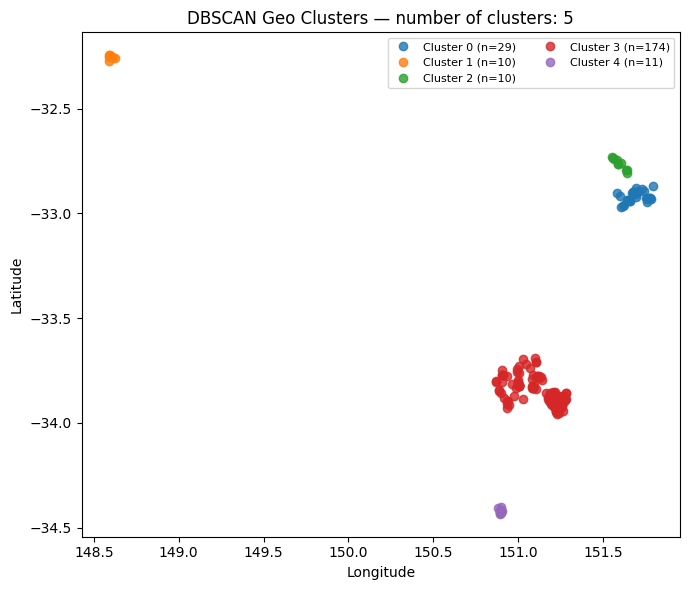

In [29]:
# Visualization: Plot DBSCAN geographic clusters of stations
labels = station_locs['geo_cluster'].to_numpy()
X = station_locs[['Longitude', 'Latitude']].to_numpy()

show_noise = False

# Number of clusters (excluding noise = -1)
unique_labels = sorted(set(labels))
n_clusters_ = len([k for k in unique_labels if k != -1])

plt.figure(figsize=(7,6))

for k in unique_labels:
    if k == -1:
        if not show_noise:
            continue
        mask = (labels == -1)
        xy = X[mask]
        if len(xy) > 0:
            plt.plot(
                xy[:,0], xy[:,1], 'x', ms=6, alpha=0.6,
                label=f'Noise (n={len(xy)})'
            )
    else:
        mask = (labels == k)
        xy = X[mask]
        if len(xy) > 0:
            # Each cluster is drawn with dots (no distinction between core/border points)
            plt.plot(
                xy[:,0], xy[:,1], 'o', ms=6, alpha=0.8,
                label=f'Cluster {k} (n={len(xy)})'
            )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'DBSCAN Geo Clusters — number of clusters: {n_clusters_}')
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Date                  542160 non-null  object 
 1   station_id            542160 non-null  int64  
 2   Station name          542160 non-null  object 
 3   Number of station     542160 non-null  float64
 4   Number of plugs       542160 non-null  float64
 5   Latitude              542160 non-null  float64
 6   Longitude             542160 non-null  float64
 7   day_of_week           542160 non-null  float64
 8   public_holiday        542160 non-null  float64
 9   school_holiday        542160 non-null  float64
 10  Avg_Temp              542160 non-null  float64
 11  Avg_Humidity          542160 non-null  float64
 12  Avg_Wind              542160 non-null  float64
 13  is_weekend            542160 non-null  float64
 14  daily_total           542160 non-null  float64
 15  

In [31]:
# Create the external factor list
cand_exog = ['public_holiday','school_holiday','Avg_Temp','Avg_Humidity','Avg_Wind','is_weekend']
exog_cols  = [c for c in cand_exog if c in df.columns]



In [32]:
# Convert the date column into the right data type
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [33]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542160 entries, 0 to 542159
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Date                  542160 non-null  datetime64[ns]
 1   station_id            542160 non-null  int64         
 2   Station name          542160 non-null  object        
 3   Number of station     542160 non-null  float64       
 4   Number of plugs       542160 non-null  float64       
 5   Latitude              542160 non-null  float64       
 6   Longitude             542160 non-null  float64       
 7   day_of_week           542160 non-null  float64       
 8   public_holiday        542160 non-null  float64       
 9   school_holiday        542160 non-null  float64       
 10  Avg_Temp              542160 non-null  float64       
 11  Avg_Humidity          542160 non-null  float64       
 12  Avg_Wind              542160 non-null  float64       
 13 

In [34]:
# Group the data by geo_cluster and date
df_group = df.groupby(['geo_cluster','Date'], as_index=True)
df_group.head(5)

,Date,station_id,Station name,Number of station,Number of plugs,Latitude,Longitude,day_of_week,public_holiday,school_holiday,Avg_Temp,Avg_Humidity,Avg_Wind,is_weekend,daily_total,estimated_demand_kWh,geo_cluster
0,2020-01-01,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,3.0,0.0,1.0,22.43,70.00,20.96,0.0,1507.0,26464.81,-1
1,2020-01-02,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,4.0,0.0,1.0,22.43,70.00,20.96,0.0,1507.0,26464.81,-1
2,2020-01-03,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,5.0,0.0,1.0,24.80,73.50,18.02,0.0,1583.0,27640.15,-1
3,2020-01-04,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,6.0,0.0,1.0,30.10,54.04,27.47,1.0,2559.0,44002.65,-1
4,2020-01-05,61,Mackellar Motel,2.0,2.0,-30.980048,150.257659,7.0,0.0,1.0,22.28,66.84,34.90,1.0,2268.0,39050.06,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524083,2025-06-26,823,1 Georges Place Parking,1.0,2.0,-34.418637,150.902172,4.0,0.0,0.0,11.02,53.69,26.18,0.0,6737.0,113848.07,4
524084,2025-06-27,823,1 Georges Place Parking,1.0,2.0,-34.418637,150.902172,5.0,0.0,0.0,11.98,67.96,19.42,0.0,6563.0,110921.29,4
524085,2025-06-28,823,1 Georges Place Parking,1.0,2.0,-34.418637,150.902172,6.0,0.0,0.0,12.90,74.27,10.93,1.0,4975.0,83743.11,4
524086,2025-06-29,823,1 Georges Place Parking,1.0,2.0,-34.418637,150.902172,7.0,0.0,0.0,12.81,75.27,11.29,1.0,4015.0,67399.05,4


In [35]:
# Create a function to create a daily time series frame aggregated by geo_cluster and Date
def make_daily_frame(df_group, y_col, exog_cols, freq='D'):
    # Create aggregation dictionary
    agg = {y_col: 'sum'}
    for c in exog_cols:
        if c in ['public_holiday', 'school_holiday', 'is_weekend']:
            agg[c] = 'max'
        else:
            agg[c] = 'mean'

    # Group by geo_cluster and Date
    g_daily = (df_group.groupby(['geo_cluster', 'Date'], as_index=True)
                        .agg(agg)
                        .sort_index())

    out_list = []
    for cid, g in g_daily.groupby(level=0):   # for each geo_cluster
        # Set Date as DatetimeIndex
        g = g.droplevel(0).sort_index()       # index = Date
        g = g.sort_index()

        # Create full date range to reindex
        full_idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)

        # Target variable y
        y = g[[y_col]].reindex(full_idx).asfreq(freq).fillna(0.0)

        # Exogenous variables X
        if exog_cols:
            # only keep exog columns that still exist after aggregation
            exog_present = [c for c in exog_cols if c in g.columns]
            X = g[exog_present].reindex(full_idx).asfreq(freq)
            # fill missing exog values with forward/backward fill
            X = X.ffill().bfill()
            out = pd.concat([y, X], axis=1)
        else:
            out = y

        out.index.name = 'Date'
        out['geo_cluster'] = cid
        out_list.append(out)

    # Combine results: includes Date + geo_cluster
    result = pd.concat(out_list).reset_index()
    return result


In [36]:
geo_data = make_daily_frame(df, 'estimated_demand_kWh', exog_cols)
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12048 entries, 0 to 12047
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  12048 non-null  datetime64[ns]
 1   estimated_demand_kWh  12048 non-null  float64       
 2   public_holiday        12048 non-null  float64       
 3   school_holiday        12048 non-null  float64       
 4   Avg_Temp              12048 non-null  float64       
 5   Avg_Humidity          12048 non-null  float64       
 6   Avg_Wind              12048 non-null  float64       
 7   is_weekend            12048 non-null  float64       
 8   geo_cluster           12048 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 847.3 KB


In [37]:
geo_data = geo_data.set_index("Date").sort_index()
geo_data.head(5)

,estimated_demand_kWh,public_holiday,school_holiday,Avg_Temp,Avg_Humidity,Avg_Wind,is_weekend,geo_cluster
Date,,,,,,,,
2020-01-01,6961596.71,0.0,1.0,22.212222,70.291667,22.471667,0.0,-1
2020-01-01,3739952.32,0.0,1.0,22.430000,70.000000,20.960000,0.0,0
2020-01-01,3325627.10,0.0,1.0,22.430000,70.000000,20.960000,0.0,2
2020-01-01,55467436.61,0.0,1.0,21.822414,71.414713,24.690690,0.0,3
2020-01-01,805671.24,0.0,1.0,22.430000,70.000000,20.960000,0.0,4


- Check outliers of the datasets using IQR

Cluster 0 | Lower bound: 1776050.38, Upper bound: 12154360.78
Outliers detected: 100


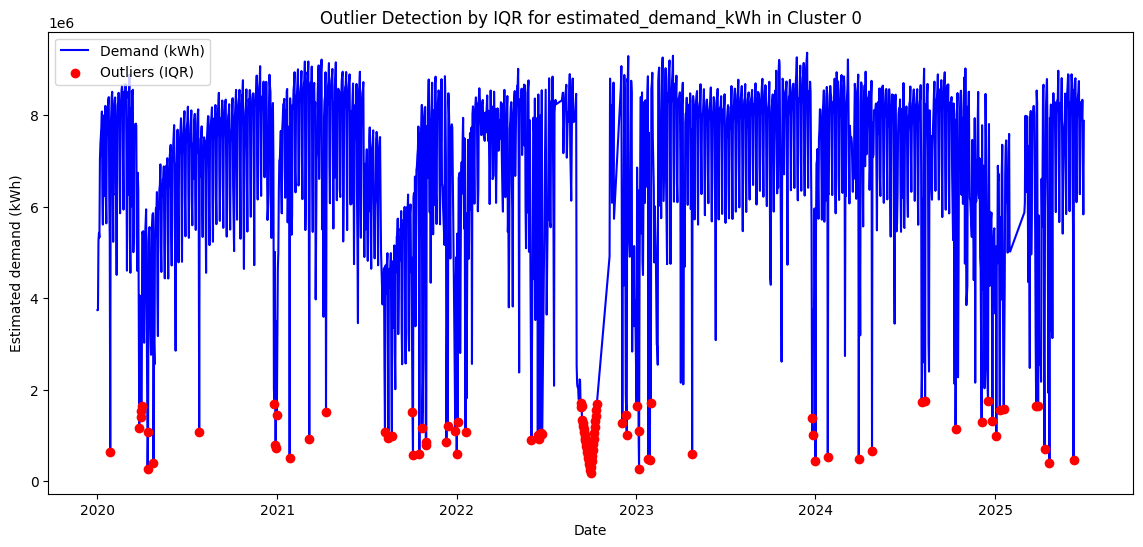

Cluster 1 | Lower bound: 110764.32, Upper bound: 818985.93
Outliers detected: 44


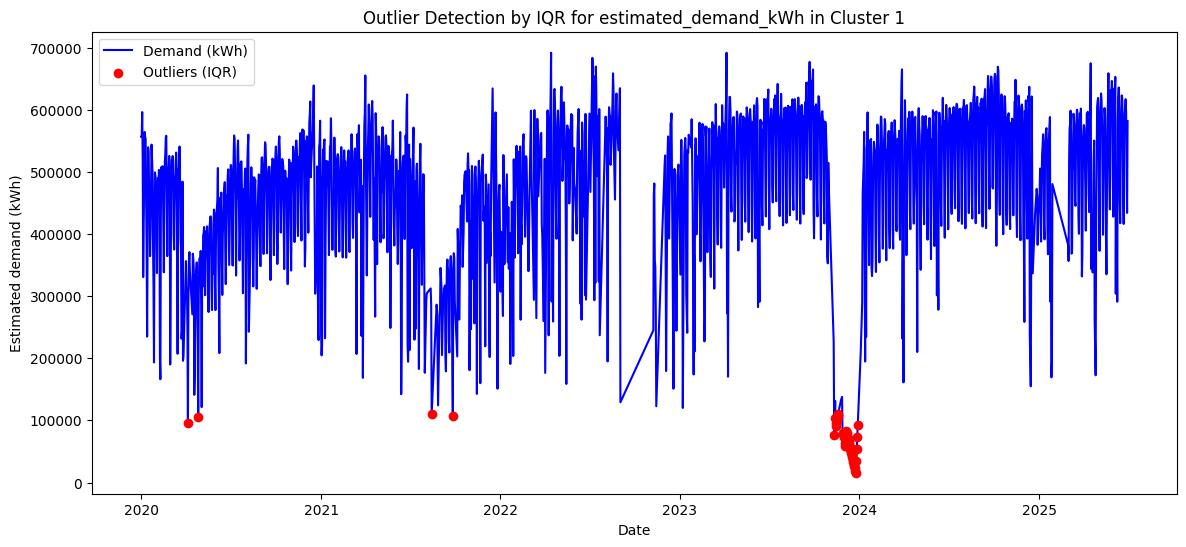

Cluster 2 | Lower bound: -239832.75, Upper bound: 8149160.16
Outliers detected: 0


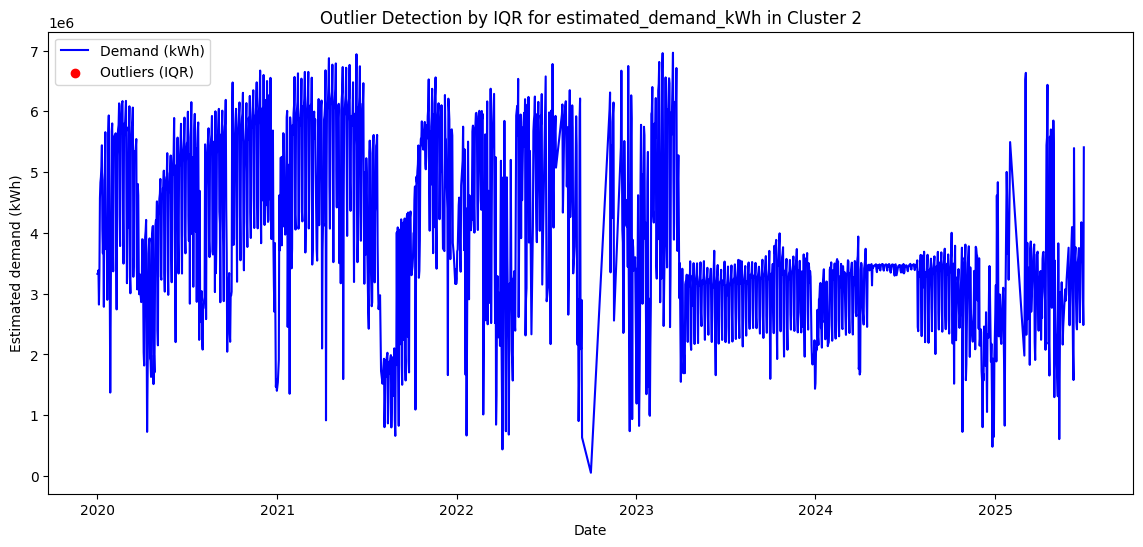

Cluster 3 | Lower bound: 31596636.86, Upper bound: 152340805.84
Outliers detected: 7


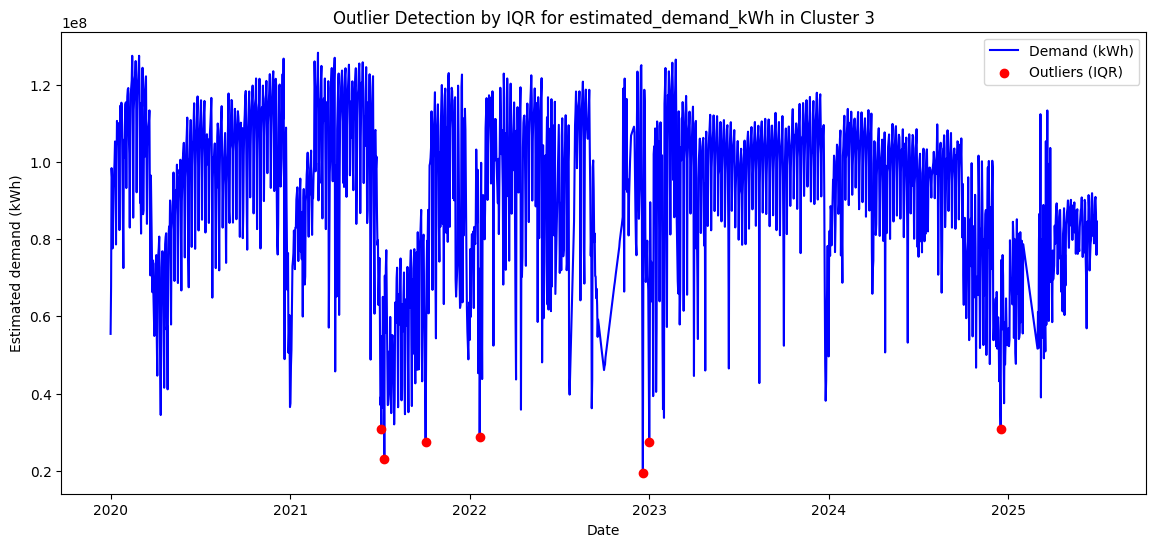

Cluster 4 | Lower bound: 155860.67, Upper bound: 1791797.93
Outliers detected: 48


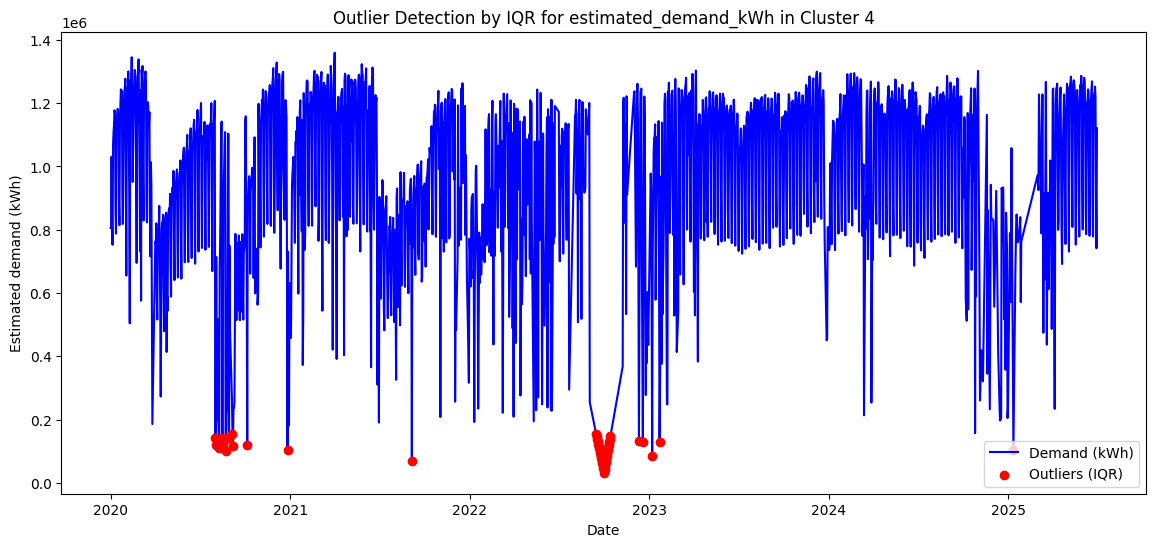

In [38]:
# Keep the same cluster range
geo_number = range(0, 5)

# Initialize outlier flag
geo_data['is_outlier'] = False

for i in geo_number:
    # Create mask index for cluster i
    idx = (geo_data['geo_cluster'] == i)

    # Get view by mask and copy for safe calculation (avoid chained assignment)
    df = geo_data.loc[idx].copy()

    # Detect outliers by IQR
    Q1 = df['estimated_demand_kWh'].quantile(0.25)
    Q3 = df['estimated_demand_kWh'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute outlier mask on df (copy)
    mask_out = (df['estimated_demand_kWh'] < lower_bound) | (df['estimated_demand_kWh'] > upper_bound)

    # CWrite results directly back into geo_data using .loc
    geo_data.loc[idx, 'is_outlier'] = mask_out.values

    # Extract outliers from geo_data for printing & plotting
    outliers = geo_data.loc[idx & geo_data['is_outlier']]

    print(f"Cluster {i} | Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"Outliers detected: {len(outliers)}")

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['estimated_demand_kWh'], label="Demand (kWh)", color="blue")
    plt.scatter(outliers.index, outliers['estimated_demand_kWh'], color="red", label="Outliers (IQR)", zorder=5)
    plt.title(f"Outlier Detection by IQR for estimated_demand_kWh in Cluster {i}")
    plt.xlabel("Date")
    plt.ylabel("Estimated demand (kWh)")
    plt.legend()
    plt.show()


In [39]:
def fix_outliers(g):
    # Build masks
    mask_event = (g['school_holiday'] == 1) | (g['public_holiday'] == 1) | (g['is_weekend'] == 1)
    mask_sensor_error = g['is_outlier'].astype(bool) & (~mask_event)

    # Work on a float copy of the target series
    s = g['estimated_demand_kWh'].astype(float)

    # Blank out the outliers so interpolation has something to fill
    s.loc[mask_sensor_error] = np.nan

    # Interpolate by time; fill edges as well
    s = s.interpolate(method='time', limit_direction='both')

    # Write back
    g['estimated_demand_kWh'] = s

    # Return original shape
    return g.reset_index()

# apply per-geo group; drop the flag after fixing
geo_clean = (
    geo_data
    .groupby("geo_cluster", group_keys=False)
    .apply(fix_outliers)
    .drop(columns=['is_outlier'])
)


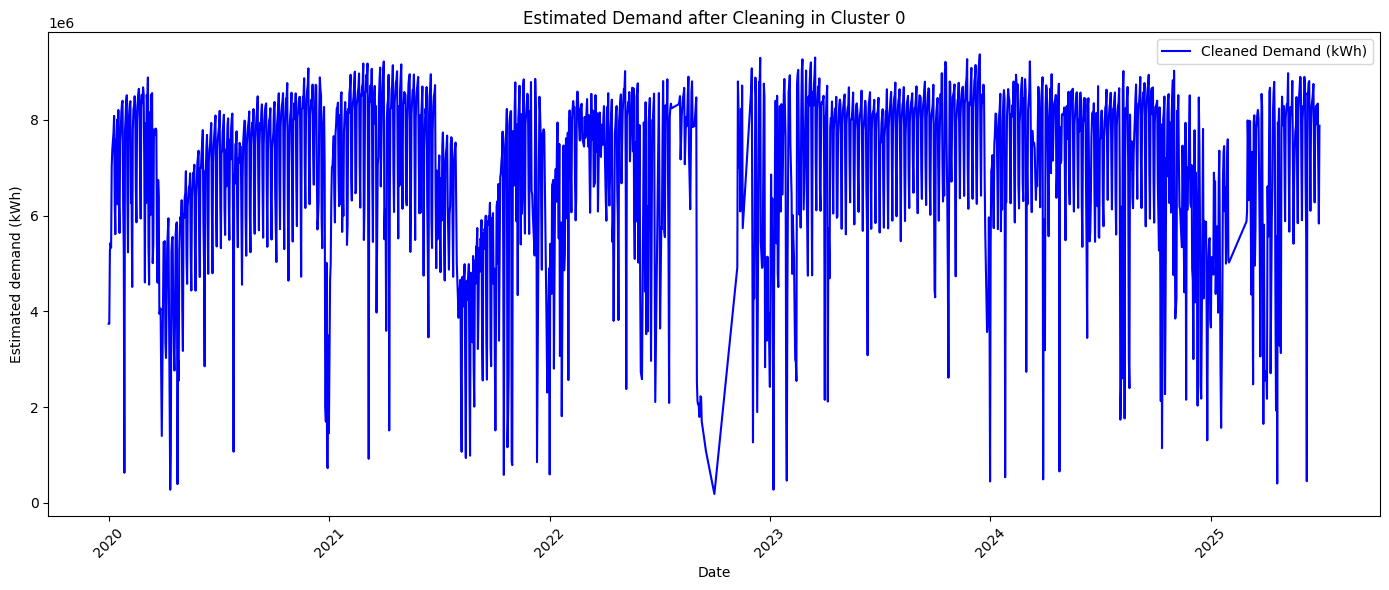

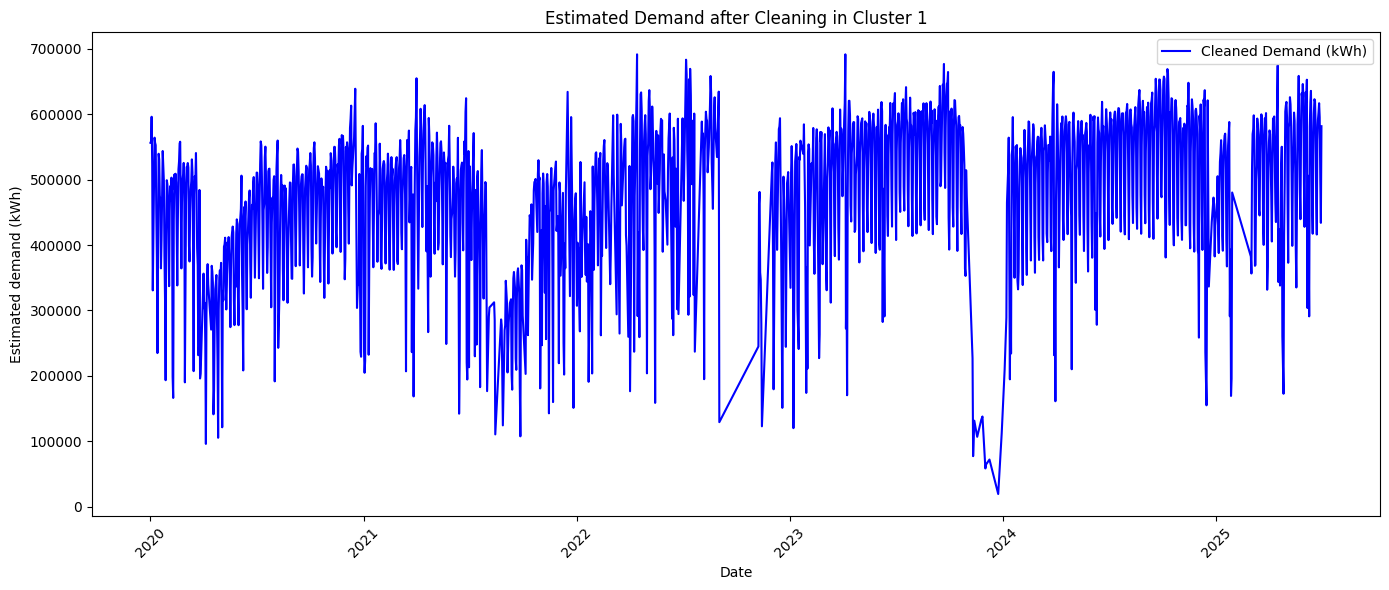

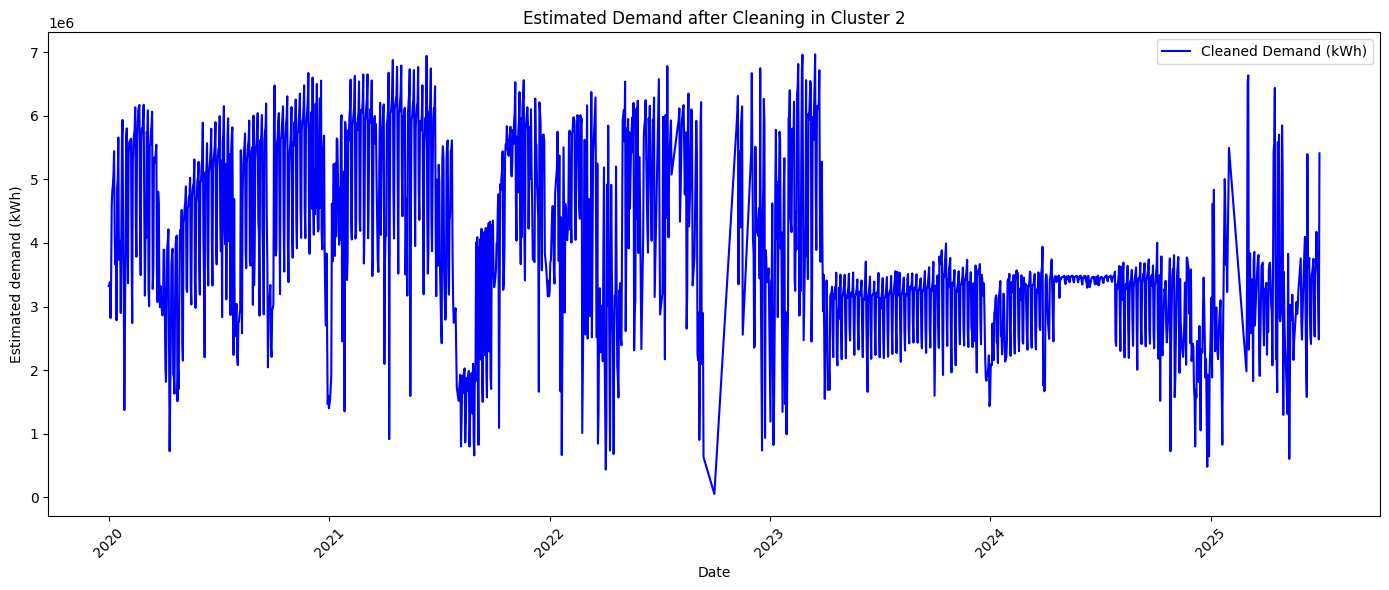

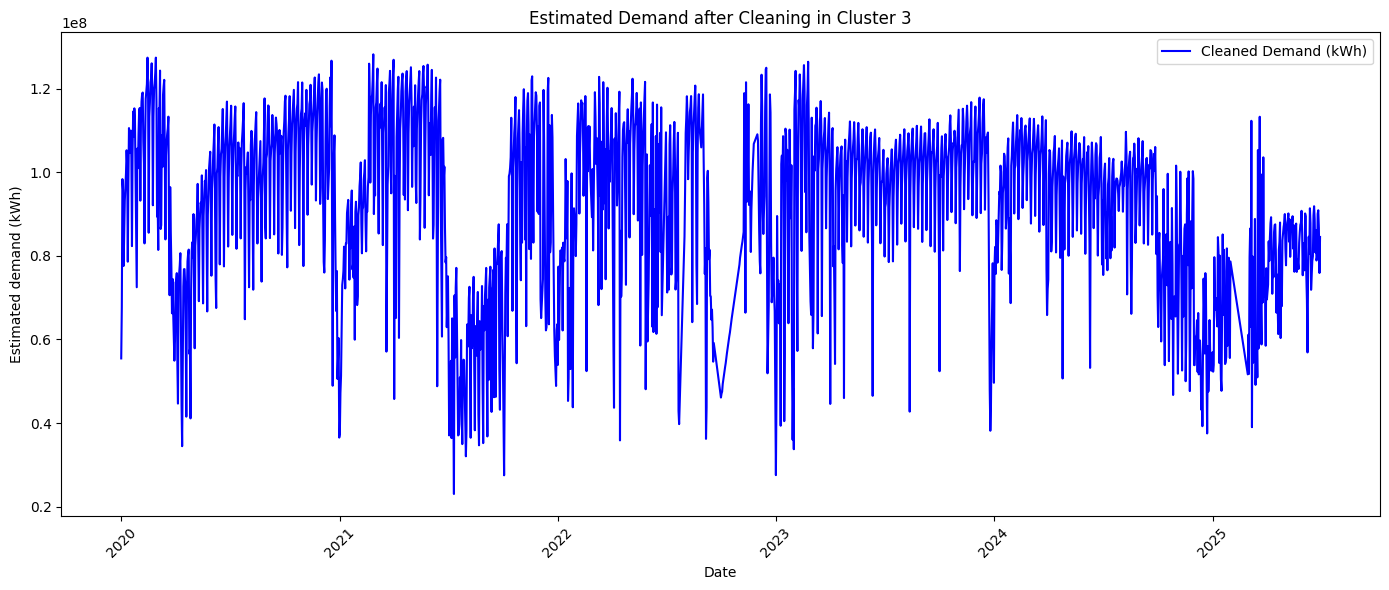

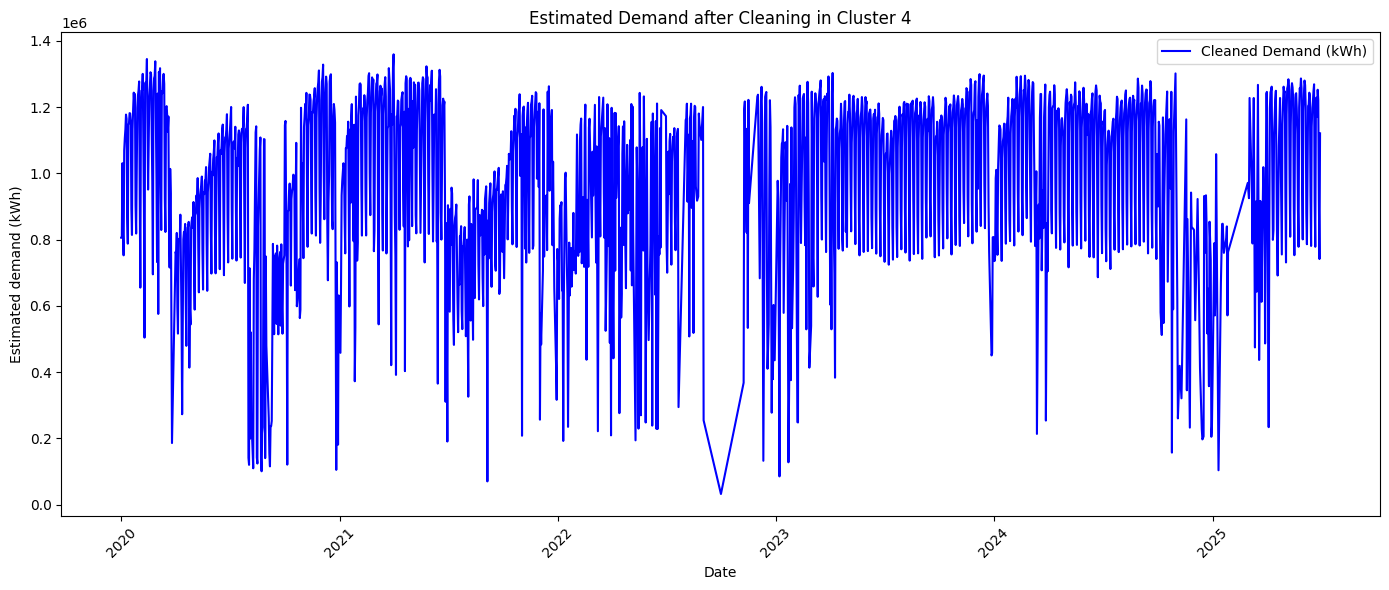

In [40]:
# Ensure Date is datetime
geo_clean['Date'] = pd.to_datetime(geo_clean['Date'])
geo_clean = geo_clean.sort_values(['geo_cluster', 'Date'])

for i in geo_number:
    # Filter cluster i
    df = geo_clean.loc[geo_clean['geo_cluster'] == i].copy()

    plt.figure(figsize=(14, 6))
    plt.plot(df['Date'], df['estimated_demand_kWh'], label="Cleaned Demand (kWh)", color="blue")

    plt.title(f"Estimated Demand after Cleaning in Cluster {i}")
    plt.xlabel("Date")
    plt.ylabel("Estimated demand (kWh)")
    plt.legend()

    # Format x-axis similar to the figure you provided
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
geo_data.to_csv('/content/drive/MyDrive/SIT764/cluster_history.csv', index=False)

#GRU Model

- Create the function to split the training and testing dataset

In [ ]:
start = 2020
end = 2023

def time_split(df, start_year, end_year):
    train_df = df.loc[f"{start_year}":f"{end_year}"]
    test_df  = df.loc[f"{end_year+1}":]
    return train_df, test_df

- Create the function to split x_train, y_train, x_test, y_test

In [ ]:
def split_sequence(sequence, n_steps, forecasting_horizon, y_index):
    X, y = list(), list()
    for i in range(len(sequence)):
      end_ix = i + n_steps
      if end_ix > len(sequence)-forecasting_horizon:
        break
      seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon, y_index]
      X.append(seq_x)
      y.append(seq_y)
    return np.array(X), np.array(y)

- Create the function to calculate the evaluation's metric

In [ ]:
def return_metrics(y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  mape = mean_absolute_percentage_error(y_true, y_pred)
  rmse = root_mean_squared_error(y_true, y_pred)
  print("MAE: {:.2f}".format(mae))
  print("MAPE: {:.2%}".format(mape))
  print("RMSE: {:2f}".format(rmse))
  return mae, mape, rmse

- Implement the GRU model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [ ]:
geo_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12048 entries, 2020-01-01 to 2025-06-30
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   estimated_demand_kWh  12048 non-null  float64
 1   public_holiday        12048 non-null  float64
 2   school_holiday        12048 non-null  float64
 3   Avg_Temp              12048 non-null  float64
 4   Avg_Humidity          12048 non-null  float64
 5   Avg_Wind              12048 non-null  float64
 6   is_weekend            12048 non-null  float64
 7   geo_cluster           12048 non-null  int64  
 8   is_outlier            12048 non-null  bool   
dtypes: bool(1), float64(7), int64(1)
memory usage: 858.9 KB


In [ ]:
GRU_result ={}

for i in geo_number:
  df = geo_clean[geo_clean['geo_cluster'] == i]
  df = df.drop(columns=['geo_cluster'])
  df.set_index('Date', inplace= True)


  #Split the trainning and testing dataset
  training_set, test_set = time_split(df, start, end)

  #Save the train
  training_set_shape = training_set.shape
  test_set_shape = test_set.shape

  #Import the min_max scaller
  sc = MinMaxScaler(feature_range =(0,1))

  #Reshape training_set
  training_set = training_set.values.reshape(-1,1)
  training_set_scaled = sc.fit_transform(training_set)
  training_set_scaled = training_set_scaled.reshape(training_set_shape[0], test_set_shape[1])

  #Parameter prepare for the model
  n_steps = 50
  forecasting_horizon = 14
  features = 7
  y_index = 0

  #Split the X_train and y_train for model
  X_train, y_train = split_sequence(training_set_scaled, n_steps, forecasting_horizon, y_index)

  #Reshaping Y_train for model
  y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)

  #Set the gru_model
  model_gru = Sequential()
  model_gru.add(GRU(units=128,activation="tanh", return_sequences=False, input_shape=(n_steps, features)))
  model_gru.add(Dropout(0.2))
  model_gru.add(Dense(units=14))
  model_gru.compile(optimizer=Adamax(learning_rate=0.001), loss='mean_squared_error')

  #Set the early stop
  early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0, restore_best_weights=True)
  model_gru.fit(X_train, y_train, epochs=200, batch_size=64, verbose=0, callbacks=[early_stop])

  #Set the RNN testing
  input_values = test_set.values.reshape(-1,1)
  input_values = sc.transform(input_values)
  input_values = input_values.reshape(test_set_shape[0], test_set_shape[1])

  #Split the X_test and y_test
  X_test, y_test = split_sequence(input_values, n_steps, forecasting_horizon, y_index)

  #Predict the values
  predict_EV_demand = model_gru.predict(X_test)
  predict_EV_demand = sc.inverse_transform(predict_EV_demand)

  #Inverst the testing values
  y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
  y_test = sc.inverse_transform(y_test)


  GRU_result[i] = {
      "model" : model_gru,
      "predict_EV_demand": predict_EV_demand,
      "y_test" : y_test,
  }



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
best_GRU_result = {}

for geo_id, res in GRU_result.items():
    y_true = res["y_test"]
    y_pred = res["predict_EV_demand"]
    horizon = min(y_true.shape[1], y_pred.shape[1])

    # Khởi tạo best cho geo_id này
    best_for_geo = {
        "horizon": None,
        "mape": float("inf"),
        "mae": None,
        "rmse":None,
        "model": None,
        "y_test": None,
        "y_pred": None,
        "dates": None
    }

    print(f"\nGeo_id: {geo_id}")
    for i in range(horizon):
        mae, mape, rmse = return_metrics(y_true[:, i], y_pred[:, i])
        print(f"Horizon {i} | MAE={mae:.2f}, MAPE={mape:.2%}, RMSE={rmse:.2f}")

        # cập nhật nếu MAPE nhỏ hơn best hiện tại của geo_id
        if mape < best_for_geo["mape"]:
            best_for_geo = {
                "horizon": i,
                "mape": mape,
                "mae": mae,
                "rmse": rmse,
                "model": res["model"],
                "y_test": y_true[:, i],
                "y_pred": y_pred[:, i],
                "dates": res["y_test"]
            }

    # lưu best cho geo_id này
    best_GRU_result[geo_id] = best_for_geo
    print("------------------")



Geo_id: 0
MAE: 1079512.03
MAPE: 34.19%
RMSE: 1584232.921178
Horizon 0 | MAE=1079512.03, MAPE=34.19%, RMSE=1584232.92
MAE: 1185881.57
MAPE: 36.63%
RMSE: 1680827.710265
Horizon 1 | MAE=1185881.57, MAPE=36.63%, RMSE=1680827.71
MAE: 1183808.20
MAPE: 36.81%
RMSE: 1691986.644760
Horizon 2 | MAE=1183808.20, MAPE=36.81%, RMSE=1691986.64
MAE: 1171972.86
MAPE: 36.82%
RMSE: 1683457.817207
Horizon 3 | MAE=1171972.86, MAPE=36.82%, RMSE=1683457.82
MAE: 1182005.95
MAPE: 37.12%
RMSE: 1689254.448107
Horizon 4 | MAE=1182005.95, MAPE=37.12%, RMSE=1689254.45
MAE: 1148606.77
MAPE: 36.74%
RMSE: 1667699.022083
Horizon 5 | MAE=1148606.77, MAPE=36.74%, RMSE=1667699.02
MAE: 1116629.94
MAPE: 36.25%
RMSE: 1677258.608972
Horizon 6 | MAE=1116629.94, MAPE=36.25%, RMSE=1677258.61
MAE: 1195830.93
MAPE: 36.59%
RMSE: 1693821.751171
Horizon 7 | MAE=1195830.93, MAPE=36.59%, RMSE=1693821.75
MAE: 1235579.55
MAPE: 37.17%
RMSE: 1731330.857015
Horizon 8 | MAE=1235579.55, MAPE=37.17%, RMSE=1731330.86
MAE: 1240049.34
MAPE: 36.9

In [ ]:
print('GRU Model')
print('------------------')
for geo_id, res in best_GRU_result.items():
    y_true = res['y_test']              # lấy trực tiếp array
    mean_val = y_true.mean()

    print(f"Geo_id: {geo_id}")
    print(f"Horizon: {res['horizon']}")
    print(f"MAPE: {res['mape']:.2%}")
    print(f"MAE:  {res['mae']:.2f}")
    print(f"RMSE: {res['rmse']:.2f}")
    print("------------------")


GRU Model
------------------
Geo_id: 0
Horizon: 0
MAPE: 34.19%
MAE:  1079512.03
RMSE: 1584232.92
------------------
Geo_id: 1
Horizon: 0
MAPE: 10.85%
MAE:  43858.79
RMSE: 63414.17
------------------
Geo_id: 2
Horizon: 0
MAPE: 18.58%
MAE:  437265.36
RMSE: 669347.95
------------------
Geo_id: 3
Horizon: 0
MAPE: 10.81%
MAE:  7738091.55
RMSE: 10868354.91
------------------
Geo_id: 4
Horizon: 0
MAPE: 20.26%
MAE:  120176.40
RMSE: 174187.52
------------------


**2. Saving train model to prepare for deploy**

In [ ]:
FEATURE_ORDER = [
    "estimated_demand_kWh",
    "public_holiday","school_holiday",
    "Avg_Temp","Avg_Humidity","Avg_Wind",
    "is_weekend"
]


In [ ]:
from pathlib import Path
import numpy as np, pandas as pd, joblib, os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model

# Directory to save artifacts
ARTIFACTS_ROOT = Path("/content/drive/MyDrive/SIT764/artifacts")
(ARTIFACTS_ROOT / "clusters").mkdir(parents=True, exist_ok=True)

# List of clusters
cluster_ids = list(best_GRU_result.keys())

for cid in cluster_ids:
    print(f"Processing cluster {cid} ...")

    # Get the original data of the cluster (same as during training)
    g = geo_clean[geo_clean["geo_cluster"] == cid].drop(columns=["geo_cluster"]).copy()
    if g.empty:
        print(f"Skip cluster {cid}: no data")
        continue

    missing = [c for c in FEATURE_ORDER if c not in g.columns]
    if missing:
        print(f"Skip cluster {cid}: missing columns {missing}")
        continue

    g = g.sort_values("Date").set_index("Date")[FEATURE_ORDER]

    # Split into train/test (can use the same split as in training)
    training_set, test_set = time_split(g, start, end)
    if len(training_set) < 60:
        print(f"Skip cluster {cid}: training too short ({len(training_set)})")
        continue

    tr_vals = training_set.values

    # Create 'flatten' scaler just like in training
    sc_all = MinMaxScaler(feature_range=(0,1))
    sc_all.fit(tr_vals.reshape(-1,1))

    # Save artifacts
    out_dir = ARTIFACTS_ROOT / f"clusters/{cid}"
    out_dir.mkdir(parents=True, exist_ok=True)

    # Model: use the model from best_GRU_result
    best_model = best_GRU_result[cid]["model"]
    best_model.save(out_dir / "model_gru.keras")

    # Scaler
    joblib.dump(sc_all, out_dir / "scaler_all.joblib")

    # Tail (50×num_features) to serve
    tail = g.tail(50).to_numpy(dtype=float)
    if tail.shape[0] != 50 or tail.shape[1] != len(FEATURE_ORDER):
        print(f"Cluster {cid}: tail shape {tail.shape} (expected 50×{len(FEATURE_ORDER)}).")
    np.save(out_dir / "tail.npy", tail)

    print(f"[SAVED] cluster {cid} → {out_dir}")

# Check saved clusters
any_dirs = [d for d in (ARTIFACTS_ROOT / "clusters").iterdir() if d.is_dir()]
print("Clusters saved:", [d.name for d in any_dirs])
if any_dirs:
    base = any_dirs[0]
    print("Files:", os.listdir(base))
    m = load_model(base / "model_gru.keras")
    sc = joblib.load(base / "scaler_all.joblib")
    tail = np.load(base / "tail.npy")
    print("Model ok?", hasattr(m, "predict"))
    print("Scaler ok?", hasattr(sc, "transform"))
    print("Tail shape:", tail.shape)


Processing cluster 0 ...
[SAVED] cluster 0 → /content/drive/MyDrive/SIT764/artifacts/clusters/0
Processing cluster 1 ...
[SAVED] cluster 1 → /content/drive/MyDrive/SIT764/artifacts/clusters/1
Processing cluster 2 ...
[SAVED] cluster 2 → /content/drive/MyDrive/SIT764/artifacts/clusters/2
Processing cluster 3 ...
[SAVED] cluster 3 → /content/drive/MyDrive/SIT764/artifacts/clusters/3
Processing cluster 4 ...
[SAVED] cluster 4 → /content/drive/MyDrive/SIT764/artifacts/clusters/4
Clusters saved: ['0', '1', '2', '3', '4']
Files: ['model_gru.keras', 'scaler_all.joblib', 'tail.npy']
Model ok? True
Scaler ok? True
Tail shape: (50, 7)
